## Naver Movie 평점과 140자평 자료를 활용한 감성 분석

https://movie.naver.com/


Web Crawling

In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")
from konlpy.tag import Twitter
import lightgbm as lgb
import requests
import pandas as pd 
from bs4 import BeautifulSoup

In [2]:
# 전체 데이터 갯수를 가져오는 함수
def get_total(num):
    url = "https://movie.naver.com/movie/point/af/list.nhn?&page="+str(num)
    response = requests.get(url)
    dom = BeautifulSoup(response.content, "html.parser")
    return dom.select_one(".h5_right_txt strong").text

# 테스트 코드
get_total(1)

'10633476'

In [3]:
# 아이템 리스트를 가져오는 함수
def get_items(num):
    url = "https://movie.naver.com/movie/point/af/list.nhn?&page="+str(num)
    response = requests.get(url)
    dom = BeautifulSoup(response.content, "html.parser")
    return dom.select(".list_netizen tbody tr")

# 테스트 코드
items = get_items(1)    
len(items)

10

In [4]:
# 아이템을 데이터 리스트로 만드는 함수
def make_datas(items):

    datas = []
    
    for item in items:
        
        try:
            point = item.select_one(".point").text             # 평점
            name = item.select_one(".title .movie").text       # 영화 제목
            con = item.select_one(".title").text             # 평
            number = item.select_one(".num").text        # 시간
            datas.append([point, name, con, number]) 

        except Exception as e:
            print(e)
            pass
        

    return datas

# 테스트 코드
datas = make_datas(items)
len(datas)

10

In [6]:
# 키워드를 입력받아 전체 데이터를 가져오는 함수
def all_datas():
    total = 50000
    pages = int(total) // 10 + 1
    datas = []
    for page in range(1, pages + 1):
        items = get_items(page)
        datas += make_datas(items)
    return datas

# 테스트 코드
datas = all_datas()
len(datas)

10000

In [7]:
# 데이터 프레임을 만드는 코드
datas = all_datas()

columns = ['Point', 'Name', 'Con', 'Number']
df = pd.DataFrame(datas, columns=columns)
df

,Point,Name,Con,Number
0,10,"그날, 바다","\n그날, 바다\n꼭 바야 할 영화 사람목숨 파리목숨으로 여기는 무서운 대한민국 ...",14022914
1,10,레옹,"\n레옹\n무슨 말이 필요함, 내용, 연기, 음악, 뭐하나 최고가 아닌 것이 없는 ...",14022913
2,2,염력,\n염력\n별루완전 별루 아무리 영화지만 상황을 너무 억지로 극단적으로 만드네 \r...,14022912
3,8,나를 기억해,\n나를 기억해\n완성도가 높진 않지만 제법 몰입이 됩니다 볼만해요 \r\n\t\...,14022911
4,6,드라이브,"\n드라이브\n영상미 음악 다 좋아요 단 스토리, 잔인 내용없다고 생각함 \r\n\...",14022910
5,10,"그날, 바다","\n그날, 바다\n그날, 바다 오늘, 진실 \r\n\t\t\t\r\n\t\t\t\r...",14022909
6,7,희생부활자,\n희생부활자\n나는 관대하다 시간때우기용으론 괜찮음 \r\n\t\t\t\r\n\t...,14022908
7,4,크리미널 스쿼드,\n크리미널 스쿼드\n빨리 끝나기를 바란 영화는 첨입니다 \r\n\t\t\t\r\n...,14022907
8,9,머니백,\n머니백\n이 영화 엄청나게 재미있다 \r\n\t\t\t\r\n\t\t\t\r\n...,14022906
9,6,콰이어트 플레이스,\n콰이어트 플레이스\n소재는 참신했으나 기대에는 못미친 \r\n\t\t\t\r\n...,14022904


In [9]:
df.to_csv("navermoviedf.csv", index=False)

---

## 2018년 4월 20일 23:30분경 크롤링 실시한 1만개 자료 (최대1만개까지 웹크롤링 가능)

### 데이터 전처리

In [260]:
df = pd.read_csv("navermoviedf.csv")

In [262]:
def remove(word):
    word = re.sub("\t신고\n", "", word)
    word = re.sub("\n", "", word)
    word = re.sub("\r", "", word)
    word = re.sub("\t", "", word)
    return word

In [263]:
df['Con'] = df['Con'].apply(remove)

In [267]:
a = []

for i in range(len(df)):
    a.append(df.Name[i])

In [268]:
a

['그날, 바다',
 '레옹',
 '염력',
 '나를 기억해',
 '드라이브',
 '그날, 바다',
 '희생부활자',
 '크리미널 스쿼드',
 '머니백',
 '콰이어트 플레이스',
 '램페이지',
 '아빠는 딸',
 '킹콩',
 '정글번치: 최강 악당의 등장',
 '레디 플레이어 원',
 '나를 기억해',
 '그날, 바다',
 '정글번치: 최강 악당의 등장',
 '정글번치: 최강 악당의 등장',
 '나를 기억해',
 '블랙 팬서',
 '저스티스 리그',
 '기억의 밤',
 '콰이어트 플레이스',
 '침대렐라',
 '궁합',
 '내 이야기!!',
 '레디 플레이어 원',
 '정글번치: 최강 악당의 등장',
 '그날, 바다',
 '그날, 바다',
 '램페이지',
 '그날, 바다',
 '골든슬럼버',
 '그날, 바다',
 '퍼시픽 림: 업라이징',
 '연평해전',
 '웜 바디스',
 '비포 선셋',
 '그날, 바다',
 '스파이더맨: 홈커밍',
 '콰이어트 플레이스',
 '리틀 포레스트',
 '토르: 라그나로크',
 '비정규직 특수요원',
 '미녀와 야수',
 '곤지암',
 '당신의 부탁',
 '퍼시픽 림: 업라이징',
 '무문관',
 '나의 서른에게',
 '레디 플레이어 원',
 '그날, 바다',
 '퍼시픽 림: 업라이징',
 '그날, 바다',
 '레디 플레이어 원',
 '핵소 고지',
 '리틀 포레스트',
 '침묵',
 '몬태나',
 '플로리다 프로젝트',
 '황금나침반',
 '골든슬럼버',
 '내 이야기!!',
 '레디 플레이어 원',
 '당신의 부탁',
 '그날, 바다',
 '램페이지',
 '아이 엠 어 히어로',
 '바람 바람 바람',
 '그날, 바다',
 '로건 럭키',
 '그날, 바다',
 '레디 플레이어 원',
 '리틀 포레스트',
 '끝까지 간다',
 '콰이어트 플레이스',
 '퍼시픽 림: 업라이징',
 '아바타',
 '지금 만나러 갑니다',
 '7년의 밤',
 '콰이어트 플레이스',
 '그날, 바다',
 '메이즈 러너',
 '콰이어트 플레이스',


In [295]:
def remove2(word):
    for j in range(len(df)):
        word = re.sub(a[j], "", word)
    return word

In [311]:
g=[]
g=[num for num in range(1,10000)]
df['Con'] = df['Con'].apply(lambda x : re.sub(a[g], "", x))

SyntaxError: Generator expression must be parenthesized if not sole argument (<ipython-input-311-8bdabc0d3111>, line 3)

In [297]:
df.tail()

,Point,Name,Con,Number
9995,2,월요일이 사라졌다,월요일이 사라졌다나쁜놈들 혼자보기 아까워서 혜자별점 줬냐 ㅋㅋㅋ리 영화 공상...,14011799
9996,6,지금 만나러 갑니다,지금 만나러 갑니다유머하고 감동받는 영화입니다,14011798
9997,8,그렘린,그렘린정말 재미있다. 그래서 아이들한테 보여주고 싶다.,14011796
9998,10,"그날, 바다","그날, 바다영화보는내내 충격이였다 울고오진않을까..걱정되어 준비해간 휴지는 하나도 ...",14011794
9999,4,램페이지,걍 그럼 솔직히 지루했음,14011792


In [2]:
df.to_csv("navermoviefinaldf.csv", index=False)

NameError: name 'df' is not defined

In [127]:
fdf = pd.read_csv("navermoviefinaldf.csv")

In [128]:
fdf.tail()

,Point,Name,Con,Number
9995,2,월요일이 사라졌다,나쁜놈들 혼자보기 아까워서 혜자별점 줬냐 ㅋㅋㅋ리 영화 공상 과학영화다 참...,14011799
9996,6,지금 만나러 갑니다,유머하고 감동받는 영화입니다,14011798
9997,8,그렘린,정말 재미있다. 그래서 아이들한테 보여주고 싶다.,14011796
9998,10,"그날, 바다",영화보는내내 충격이였다 울고오진않을까..걱정되어 준비해간 휴지는 하나도 쓰지를 않았...,14011794
9999,4,램페이지,걍 그럼 솔직히 지루했음,14011792


In [129]:
from konlpy.tag import Twitter
from konlpy.tag import *
hannanum = Hannanum()
kkma = Kkma()
twitter = Twitter()

def tokenize_pos(doc):
    return ['/'.join(t) for t in twitter.pos(doc)]

In [130]:
clf = Pipeline([
    ("vect", TfidfVectorizer(tokenizer=tokenize_pos, ngram_range=(1,2))), 
    ("clf", MultinomialNB(alpha=0.01))
])

In [131]:
X_train_D, X_test_D, y_train_D, y_test_D = train_test_split(fdf['Con'], fdf['Point'], \
                                                    test_size=0.4, random_state=0)

len(X_train_D),len(X_test_D),len(y_train_D),len(y_test_D)

(6000, 4000, 6000, 4000)

In [132]:
def naver_movie():
    model_D = clf.fit(X_train_D, y_train_D)
    
    y_pred_D = model_D.predict(X_train_D)
    
    print("Train", "\n")
    print("Train confusion_matrix", "\n")
    print(confusion_matrix(y_train_D, y_pred_D), "\n\n")
    print("Train classification_report", "\n")
    print(classification_report(y_train_D, y_pred_D), "\n\n")
    print("Train accuracy_score", "\n")
    print(round(accuracy_score(y_train_D, y_pred_D), 2), "\n\n")
    
    print("=====================================================" , "\n\n")
    
    y_pred_D_T = model_D.predict(X_test_D)
    
    print("Test", "\n")
    print("Test confusion_matrix", "\n")
    print(confusion_matrix(y_test_D, y_pred_D_T), "\n\n")
    print("Test classification_report", "\n")
    print(classification_report(y_test_D, y_pred_D_T), "\n\n")
    print("Test accuracy_score", "\n")
    print(round(accuracy_score(y_test_D, y_pred_D_T), 2), "\n\n")
    
    x="Train","Test"
    y=accuracy_score(y_train_D, y_pred_D), accuracy_score(y_test_D, y_pred_D_T)
    plt.bar(x,y)
    plt.show()

Train 

Train confusion_matrix 

[[ 591    1    0    0    0    0    0    0    0    1]
 [   0  191    0    0    0    0    0    1    0    0]
 [   0    0   56    0    0    0    0    0    0    0]
 [   0    0    0  128    0    0    0    0    0    0]
 [   0    0    0    0  102    0    0    0    0    0]
 [   0    0    0    0    0  323    0    1    0    0]
 [   0    0    0    0    0    0  257    1    0    0]
 [   0    0    0    0    0    0    0  610    0    5]
 [   0    0    0    0    0    0    0    1  370    2]
 [   0    0    0    0    0    1    0    4    0 3354]] 


Train classification_report 

             precision    recall  f1-score   support

          1       1.00      1.00      1.00       593
          2       0.99      0.99      0.99       192
          3       1.00      1.00      1.00        56
          4       1.00      1.00      1.00       128
          5       1.00      1.00      1.00       102
          6       1.00      1.00      1.00       324
          7       1.00      1.0

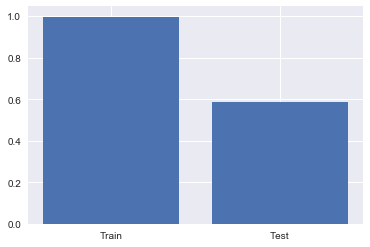

In [133]:
naver_movie()

In [135]:
def CountVectorizer_naver_con():
    vect = CountVectorizer()
    vect.fit(fdf['Con'])
    #vect.vocabulary_
    
    check_BQ = vect.transform(fdf['Con']).toarray()
    
    check_BQ = pd.DataFrame(check_BQ)
    
    check_BQ['y'] = fdf['Point']
    
    return check_BQ

check_BQ = CountVectorizer_naver_con()

In [136]:
check_BQ.tail()

,0,1,2,3,4,5,6,7,8,9,...,38785,38786,38787,38788,38789,38790,38791,38792,38793,y
9995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
9997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
9998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
9999,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


In [36]:
le = LabelEncoder()

y_train = le.fit_transform(check_BQ['y'])
X_train = check_BQ.drop("y",axis=1)

print("Start1")
model_1 = lgb.LGBMClassifier(nthread=3)
scores_1 = cross_val_score(estimator=model_1, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_1.mean(), scores_1.std() * 2), '-> None')
print("End")
print(" ")

print("Start2")
model_2 = lgb.LGBMClassifier(nthread=3, reg_alpha=0.5)
scores_2 = cross_val_score(estimator=model_2, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_2.mean(), scores_2.std() * 2), '-> reg_alpha=0.5')
print("End")
print(" ")

print("Start3")
model_3 = lgb.LGBMClassifier(nthread=3, reg_alpha=1)
scores_3 = cross_val_score(estimator=model_3, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_3.mean(), scores_3.std() * 2), '-> reg_alpha=1')
print("End")
print(" ")

print("Start4")
model_4 = lgb.LGBMClassifier(nthread=3, reg_alpha=0.5, learning_rate=0.05, n_estimator=200)
scores_4 = cross_val_score(estimator=model_4, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_4.mean(), scores_4.std() * 2), '-> reg_alpha=0.5, l_r=0.05, n_estimator=200')
print("End")
print(" ")

print("Start5")
model_5 = lgb.LGBMClassifier(nthread=3, reg_alpha=1, learning_rate=0.05, n_estimator=300)
scores_5 = cross_val_score(estimator=model_5, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_5.mean(), scores_5.std() * 2), '-> reg_alpha=1, l_r=0.05, n_estimator=300')
print("End")
print(" ")

print("Trial_Error")
model_6 = lgb.LGBMClassifier(nthread=3, n_estimators=200)
scores_6 = cross_val_score(estimator=model_6, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_6.mean(), scores_6.std() * 2), '-> n_estimator=200')
print("End")
print(" ")

Start1


KeyboardInterrupt: 

In [146]:
X_train_CD, X_test_CD, y_train_CD, y_test_CD = train_test_split(check_BQ.drop("y", axis=1), check_BQ['y'], \
                                                    test_size=0.4, random_state=0)

len(X_train_CD),len(X_test_CD),len(y_train_CD),len(y_test_CD)

(6000, 4000, 6000, 4000)

In [147]:
def naver_movie_lgb():
    
    model_lgb = lgb.LGBMClassifier(nthread=3, reg_alpha=0.5, l_r=0.05, n_estimator=200)
    model_lgb.fit(X_train_CD, y_train_CD)
    
    y_pred_l = model_lgb.predict(X_train_CD)
    
    print("Train", "\n")
    print("Confusion_Matrix", "\n")
    print(confusion_matrix(y_train_CD, y_pred_l), "\n\n")

    print("Classification_Report", "\n")
    print(classification_report(y_train_CD, y_pred_l), "\n\n")

    print("Accuracy_Score", "\n")
    print(round(accuracy_score(y_train_CD, y_pred_l),2), "\n\n")
    
    print("=====================================================" , "\n\n")
    
    y_pred_l_T = model_lgb.predict(X_test_CD)
    
    print("Test", "\n")
    print("Confusion_Matrix", "\n")
    print(confusion_matrix(y_test_CD, y_pred_l_T), "\n\n")

    print("Classification_Report", "\n")
    print(classification_report(y_test_CD, y_pred_l_T), "\n\n")

    print("Accuracy_Score", "\n")
    print(round(accuracy_score(y_test_CD, y_pred_l_T),2))
    
    x="Train","Test"
    y=accuracy_score(y_train_CD, y_pred_l), accuracy_score(y_test_CD, y_pred_l_T)
    plt.bar(x,y)
    plt.show()

Train 

Confusion_Matrix 

[[  76    0    0    0    0    0    0    9    0  508]
 [   9    9    0    0    0    4    1    4    0  165]
 [   3    0    3    0    0    0    1    2    0   47]
 [   6    0    0    3    0    2    1    5    0  111]
 [   2    0    0    0    6    2    1    3    0   88]
 [  10    1    0    0    0   21    0   14    1  277]
 [   4    1    0    0    0    3   19    9    1  221]
 [   2    1    0    1    0    1    0   79    2  529]
 [   3    0    0    0    0    0    1   13   34  322]
 [  31    0    0    0    0    3    0   17    1 3307]] 


Classification_Report 

             precision    recall  f1-score   support

          1       0.52      0.13      0.21       593
          2       0.75      0.05      0.09       192
          3       1.00      0.05      0.10        56
          4       0.75      0.02      0.05       128
          5       1.00      0.06      0.11       102
          6       0.58      0.06      0.12       324
          7       0.79      0.07      0.13 

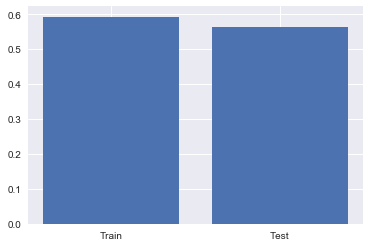

In [148]:
naver_movie_lgb()

---

### 감성 축소

In [152]:
def new_category():
    fdf = pd.read_csv("navermoviefinaldf.csv")
    fdfc = fdf[fdf['Point'].isin(["1","2","3","8","9","10"])].reset_index(drop=True)
    fdfc['category'] = fdfc['Point']
    fdfc['category'].replace([1,2,3,8,9,10], ["0","0","0","1","1","1"], inplace=True)
    
    return fdfc

fdfc = new_category()

In [153]:
fdfc.tail()

,Point,Name,Con,Number,category
8609,10,리틀 포레스트,나는 보는 내내 배가 고팠다.,14011801,1
8610,10,"그날, 바다",예고편만 봐도 소름진실이 꼭 드러나기를 바랍니다.,14011800,1
8611,2,월요일이 사라졌다,나쁜놈들 혼자보기 아까워서 혜자별점 줬냐 ㅋㅋㅋ리 영화 공상 과학영화다 참...,14011799,0
8612,8,그렘린,정말 재미있다. 그래서 아이들한테 보여주고 싶다.,14011796,1
8613,10,"그날, 바다",영화보는내내 충격이였다 울고오진않을까..걱정되어 준비해간 휴지는 하나도 쓰지를 않았...,14011794,1


In [72]:
from konlpy.tag import Twitter
from konlpy.tag import *
hannanum = Hannanum()
kkma = Kkma()
twitter = Twitter()

def tokenize_pos(doc):
    return ['/'.join(t) for t in twitter.pos(doc)]

In [79]:
clf = Pipeline([
    ("vect", TfidfVectorizer(tokenizer=tokenize_pos, ngram_range=(1,2))), 
    ("clf", MultinomialNB(alpha=0.05))
])

In [80]:
X_train_D, X_test_D, y_train_D, y_test_D = train_test_split(fdfc['Con'], fdfc['category'], \
                                                    test_size=0.2, random_state=0)

len(X_train_D),len(X_test_D),len(y_train_D),len(y_test_D)

(6891, 1723, 6891, 1723)

In [81]:
def naver_movie():
    model_D = clf.fit(X_train_D, y_train_D)
    
    y_pred_D = model_D.predict(X_train_D)
    
    print("Train", "\n")
    print("Train confusion_matrix", "\n")
    print(confusion_matrix(y_train_D, y_pred_D), "\n\n")
    print("Train classification_report", "\n")
    print(classification_report(y_train_D, y_pred_D), "\n\n")
    print("Train accuracy_score", "\n")
    print(round(accuracy_score(y_train_D, y_pred_D), 2), "\n\n")
    
    print("=====================================================" , "\n\n")
    
    y_pred_D_T = model_D.predict(X_test_D)
    
    print("Test", "\n")
    print("Test confusion_matrix", "\n")
    print(confusion_matrix(y_test_D, y_pred_D_T), "\n\n")
    print("Test classification_report", "\n")
    print(classification_report(y_test_D, y_pred_D_T), "\n\n")
    print("Test accuracy_score", "\n")
    print(round(accuracy_score(y_test_D, y_pred_D_T), 2), "\n\n")
    
    x="Train","Test"
    y=accuracy_score(y_train_D, y_pred_D), accuracy_score(y_test_D, y_pred_D_T)
    plt.bar(x,y)
    plt.show()

Train 

Train confusion_matrix 

[[1083    4]
 [   1 5803]] 


Train classification_report 

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1087
          1       1.00      1.00      1.00      5804

avg / total       1.00      1.00      1.00      6891
 


Train accuracy_score 

1.0 




Test 

Test confusion_matrix 

[[ 106  166]
 [  12 1439]] 


Test classification_report 

             precision    recall  f1-score   support

          0       0.90      0.39      0.54       272
          1       0.90      0.99      0.94      1451

avg / total       0.90      0.90      0.88      1723
 


Test accuracy_score 

0.9 




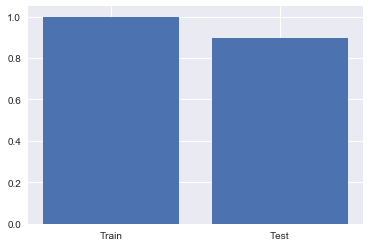

In [82]:
naver_movie()

In [154]:
def CountVectorizer_naver_con():
    vect = CountVectorizer()
    vect.fit(fdfc['Con'])
    #vect.vocabulary_
    
    check_BQ = vect.transform(fdfc['Con']).toarray()
    
    check_BQ = pd.DataFrame(check_BQ)
    
    check_BQ['y'] = fdfc['category']
    
    return check_BQ

check_BQ = CountVectorizer_naver_con()

In [36]:
le = LabelEncoder()

y_train = le.fit_transform(check_BQ['y'])
X_train = check_BQ.drop("y",axis=1)

print("Start1")
model_1 = lgb.LGBMClassifier(nthread=3)
scores_1 = cross_val_score(estimator=model_1, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_1.mean(), scores_1.std() * 2), '-> None')
print("End")
print(" ")

print("Start2")
model_2 = lgb.LGBMClassifier(nthread=3, reg_alpha=0.5)
scores_2 = cross_val_score(estimator=model_2, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_2.mean(), scores_2.std() * 2), '-> reg_alpha=0.5')
print("End")
print(" ")

print("Start3")
model_3 = lgb.LGBMClassifier(nthread=3, reg_alpha=1)
scores_3 = cross_val_score(estimator=model_3, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_3.mean(), scores_3.std() * 2), '-> reg_alpha=1')
print("End")
print(" ")

print("Start4")
model_4 = lgb.LGBMClassifier(nthread=3, reg_alpha=0.5, learning_rate=0.05, n_estimator=200)
scores_4 = cross_val_score(estimator=model_4, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_4.mean(), scores_4.std() * 2), '-> reg_alpha=0.5, l_r=0.05, n_estimator=200')
print("End")
print(" ")

print("Start5")
model_5 = lgb.LGBMClassifier(nthread=3, reg_alpha=1, learning_rate=0.05, n_estimator=300)
scores_5 = cross_val_score(estimator=model_5, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_5.mean(), scores_5.std() * 2), '-> reg_alpha=1, l_r=0.05, n_estimator=300')
print("End")
print(" ")

print("Trial_Error")
model_6 = lgb.LGBMClassifier(nthread=3, n_estimators=200)
scores_6 = cross_val_score(estimator=model_6, X=X_train, y=y_train, cv=4, scoring='neg_log_loss')
print("log_loss: %0.2f (%0.2f)" % (scores_6.mean(), scores_6.std() * 2), '-> n_estimator=200')
print("End")
print(" ")

Start1


KeyboardInterrupt: 

In [167]:
X_train_CD, X_test_CD, y_train_CD, y_test_CD = train_test_split(check_BQ.drop("y", axis=1), check_BQ['y'], \
                                                    test_size=0.3, random_state=0)

len(X_train_CD),len(X_test_CD),len(y_train_CD),len(y_test_CD)

(6029, 2585, 6029, 2585)

In [168]:
def naver_movie_lgb():
    
    model_lgb = lgb.LGBMClassifier(nthread=3, reg_alpha=0.5, l_r=0.05, n_estimator=200)
    model_lgb.fit(X_train_CD, y_train_CD)
    
    y_pred_l = model_lgb.predict(X_train_CD)
    
    print("Train", "\n")
    print("Confusion_Matrix", "\n")
    print(confusion_matrix(y_train_CD, y_pred_l), "\n\n")

    print("Classification_Report", "\n")
    print(classification_report(y_train_CD, y_pred_l), "\n\n")

    print("Accuracy_Score", "\n")
    print(round(accuracy_score(y_train_CD, y_pred_l),2), "\n\n")
    
    print("=====================================================" , "\n\n")
    
    y_pred_l_T = model_lgb.predict(X_test_CD)
    
    print("Test", "\n")
    print("Confusion_Matrix", "\n")
    print(confusion_matrix(y_test_CD, y_pred_l_T), "\n\n")

    print("Classification_Report", "\n")
    print(classification_report(y_test_CD, y_pred_l_T), "\n\n")

    print("Accuracy_Score", "\n")
    print(round(accuracy_score(y_test_CD, y_pred_l_T),2))
    
    x="Train","Test"
    y=accuracy_score(y_train_CD, y_pred_l), accuracy_score(y_test_CD, y_pred_l_T)
    plt.bar(x,y)
    plt.show()

Train 

Confusion_Matrix 

[[ 161  795]
 [  45 5028]] 


Classification_Report 

             precision    recall  f1-score   support

          0       0.78      0.17      0.28       956
          1       0.86      0.99      0.92      5073

avg / total       0.85      0.86      0.82      6029
 


Accuracy_Score 

0.86 




Test 

Confusion_Matrix 

[[  44  359]
 [  28 2154]] 


Classification_Report 

             precision    recall  f1-score   support

          0       0.61      0.11      0.19       403
          1       0.86      0.99      0.92      2182

avg / total       0.82      0.85      0.80      2585
 


Accuracy_Score 

0.85


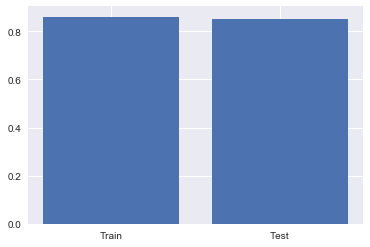

In [169]:
naver_movie_lgb()